<a href="https://colab.research.google.com/github/ragibayon/Data-Science-Projects/blob/master/Python/Reducing%20type%20II%20error%20of%20early%20stage%20diabetics%20prediction%20using%20voting%20classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting early stage diabetics

We need to go through the following steps for predicting early stage diabetics:
1. Data wrangling
2. Exploratory Data Analysis
3. Data preprocessing and Feature Importance Analysis
4. evaluating machine learning models
5. creating ensamble model for robustness


## Load the data set into memory

This is a very small dataset consisting only 520 instances and cosumes approximately 70 KB so we can load all of it into memory, but for huge datasets we need to process them chunk by chunk.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# df = pd.read_csv("/kaggle/input/early-stage-diabetes-risk-prediction-dataset/diabetes_data_upload.csv") #for kaggle
# df = pd.read_csv("/content/drive/MyDrive/Research 2021/Likelihood of Early Stage Diabetics /diabetes_data.csv") # for colab
# df = pd.read_csv("diabetes_data_upload.csv")

df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


## Data Wrangling

Data wrangling is the process of gathering, selecting, and transforming data to answer an analytical question. Also known as data cleaning or munging, legend has it that this wrangling costs analytics professionals as much as 80% of their time, leaving only 20% for exploration and modeling.

But the dataset is pre cleaned and there is no missing data. As a result, it is quite an easy step here and there is not much to do.

In [4]:
# Check the data types of the columns and if there is any null value.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

## Exploratory Data Analysis

In this section, we will try to infer about the trends in the dataset using data visualization and statistics. 

We can see that every columns without age consists of boolean values. So at first we need to encode them by using *LabelEncoder*. As these are boolean categorical values we cannot use [*pandas.DataFrame.describe*](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html) to infer about the descriptive statistics including those that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

Rather we can analyze the frequency of attributes over different age groups and gender.

In [5]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
for column  in df.columns[1:]:
    df[column]= label_encoder.fit_transform(df[column])

In [6]:
# descriptive statistics of the Age column
df.Age.describe()

count    520.000000
mean      48.028846
std       12.151466
min       16.000000
25%       39.000000
50%       47.500000
75%       57.000000
max       90.000000
Name: Age, dtype: float64

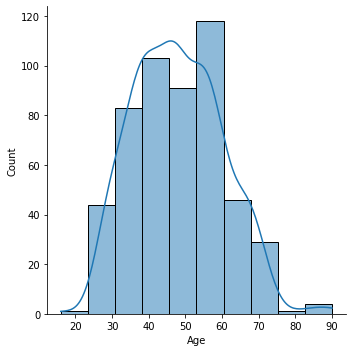

In [7]:
# Distribution of patients age. 
sns.displot(x='Age', kind ='hist', data= df, bins = 10, kde = True);

## Data Pre processing and Feature Important analysis

the dataset is already pre-processed and there is not much to do. But we can check what are the most important features of this data set by: Finding out the pearson correlation between features and Class Feature importance techniues to reduce computational cost.


### Correlation analysis

Correlation is not casuation but we can infer which features attributes most in defining the class. So that, we can also reduce relatively insignificant features for reducing load in machine learning models. we have taken pearson correlation coefficient 

In [8]:
# taking the abosulute values of the correlating features to find out top 5 features
np.abs(df.iloc[:,:-1].corrwith(df['class'])).sort_values(ascending = False)

Polyuria              0.665922
Polydipsia            0.648734
Gender                0.449233
sudden weight loss    0.436568
partial paresis       0.432288
Polyphagia            0.342504
Irritability          0.299467
Alopecia              0.267512
visual blurring       0.251300
weakness              0.243275
muscle stiffness      0.122474
Genital thrush        0.110288
Age                   0.108679
Obesity               0.072173
delayed healing       0.046980
Itching               0.013384
dtype: float64

### Feture importance

which features are important is analyzed using RandomForestClassifier from sklearn.ensemble method. This is done in the Predictive analytics section bellow. From that we can see that *Age* is one of the most important factors but it is not quite correlated with the target variable *Class*.

So, we should not rely on only one method in determing important features for predicting the target.

## Predictive Analytics

In predictive analytics, we need to come to an strategy for making a robust classifier to classify the likelyhood of a person having early stage diabetics by using new features. In this project, our goal should be minimizing false positives even if it reduces over all accuracy.

In this step we need to:
* split the dataset in training and testing dataset
* find out the classification accuracy of a naive classifier
* compare differnt classifier usign F1 score, precision, recall, accuracy and confusion matrix.
* create an ensemble classifier using the top three classifiers 

In [9]:
# importing necessary libraries
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix

In [10]:
predictors = df.drop(['class'], axis= 1)
target = df['class']
x_train, x_val, y_train, y_val = train_test_split(predictors, target, test_size = 0.10, random_state = 0, stratify=target)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(468, 16) (468,)
(52, 16) (52,)


## Creating a Baseline Regression Model

DummyRegressor allows us to create a very simple model that we can use as a baseline to compare against our actual model. This can often be useful to simulate a “naive” existing prediction process in a product or system.

score returns the coefficient of determination $(R-squared, R^2)$. The closer $R^2$ is to 1, the more of the variance in the target vector that is explained by
the features.

In [11]:
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy='mean')
dummy.fit(x_train, y_train)
dummy.score(x_val, y_val)

0.0

**Null Accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [12]:
y_train.value_counts()

1    288
0    180
Name: class, dtype: int64

In [13]:
y_train.mean()

0.6153846153846154

In [14]:
classifiers_description = {"model":[],"precision":[], "recall":[],"f1-score":[], "accuracy":[], "standard_deviation" :[]}

In [15]:
def model_accuracy(classifier = None, predictors=None, target= None, n_splits = 10):
    global classifiers_description
    # helper function for Model Evaluation
    
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    
    y_pred = cross_val_predict(classifier, predictors, target, cv=kf)
    scores = cross_val_score(classifier, predictors, target, cv=kf)
    
    # plotting confusion matrix

    cf_matrix = confusion_matrix(target, y_pred)
    sns.set_style('ticks')
    fig, ax = plt.subplots()
    sns.heatmap(cf_matrix,annot=True, ax=ax, fmt='g', cmap='Blues')

    #making classifier description report
    report = classification_report(target, y_pred, output_dict=True)
    classifier_name = type(classifier).__name__
    if classifier_name not in classifiers_description["model"]:
        classifiers_description["model"].append(classifier_name)
        classifiers_description["precision"].append(report['weighted avg']["precision"])
        classifiers_description["recall"].append(report['weighted avg']["recall"])
        classifiers_description["f1-score"].append(report['weighted avg']["f1-score"])
        classifiers_description["accuracy"].append(scores.mean())
        classifiers_description["standard_deviation"].append(scores.std())   

    
    print(classification_report(target, y_pred))

    return (scores.mean(), scores.std())

              precision    recall  f1-score   support

           0       0.85      0.83      0.84       200
           1       0.90      0.91      0.90       320

    accuracy                           0.88       520
   macro avg       0.87      0.87      0.87       520
weighted avg       0.88      0.88      0.88       520



(0.8788461538461538, 0.055769230769230786)

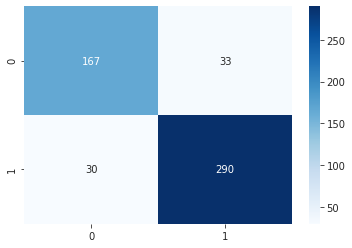

In [16]:
from sklearn.naive_bayes import GaussianNB
clf_GNB = GaussianNB()
model_accuracy(classifier=clf_GNB, predictors=predictors, target=target)


              precision    recall  f1-score   support

           0       0.90      0.91      0.90       200
           1       0.94      0.93      0.94       320

    accuracy                           0.92       520
   macro avg       0.92      0.92      0.92       520
weighted avg       0.92      0.92      0.92       520



(0.923076923076923, 0.032179231789772146)

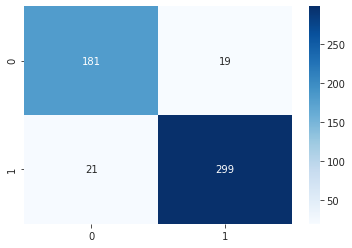

In [17]:
from sklearn.linear_model import LogisticRegression
clf_LR= LogisticRegression(max_iter=1000, )
model_accuracy(classifier=clf_LR, predictors=predictors, target=target)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.98      0.98      0.98       320

    accuracy                           0.97       520
   macro avg       0.97      0.97      0.97       520
weighted avg       0.97      0.97      0.97       520



(0.9692307692307691, 0.019611613513818398)

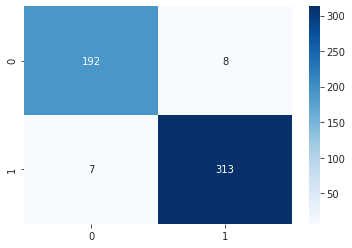

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf_DT = DecisionTreeClassifier()
model_accuracy(classifier=clf_DT, predictors=predictors, target=target)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       200
           1       0.99      0.98      0.98       320

    accuracy                           0.98       520
   macro avg       0.98      0.98      0.98       520
weighted avg       0.98      0.98      0.98       520



(0.9807692307692306, 0.022754153011921602)

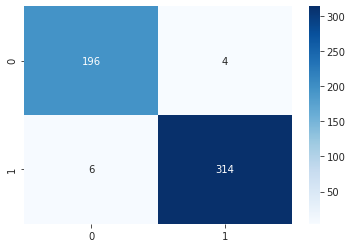

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf_RF = RandomForestClassifier()
model_accuracy(classifier=clf_RF, predictors=predictors, target=target)

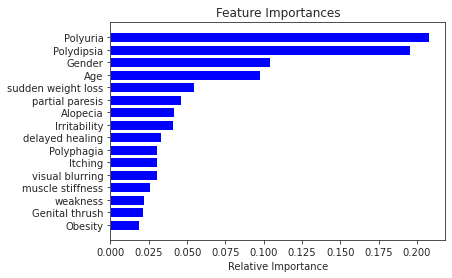

In [20]:
# plotting feature importances

from sklearn.ensemble import RandomForestClassifier

# fitting the model
model_RF = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
model_RF.fit(x_train, y_train)

features = df.drop('class', axis=1).columns
importances = model_RF.feature_importances_
indices = np.argsort(importances)

plt.figure()
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.98      0.98      0.98       320

    accuracy                           0.97       520
   macro avg       0.97      0.97      0.97       520
weighted avg       0.98      0.97      0.98       520



(0.975, 0.022835273244303685)

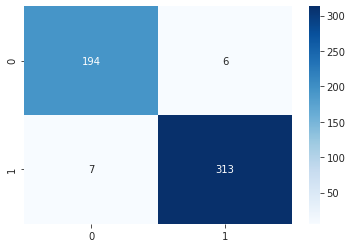

In [21]:
from sklearn.ensemble import GradientBoostingClassifier
clf_GBC = GradientBoostingClassifier()
model_accuracy(classifier=clf_GBC, predictors=predictors, target=target)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       200
           1       0.97      0.97      0.97       320

    accuracy                           0.97       520
   macro avg       0.97      0.97      0.97       520
weighted avg       0.97      0.97      0.97       520



(0.9673076923076923, 0.031068258502699047)

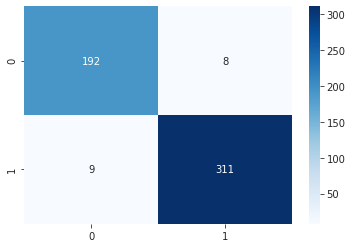

In [22]:
from sklearn.neural_network import MLPClassifier
MLP_clf = MLPClassifier(random_state=1, max_iter=10000)
model_accuracy(classifier=MLP_clf, predictors=predictors, target=target)

In [23]:
classifier_df = pd.DataFrame.from_dict(classifiers_description)
classifier_df.sort_values(by=["f1-score","standard_deviation"], ascending=False)

,model,precision,recall,f1-score,accuracy,standard_deviation
3,RandomForestClassifier,0.980835,0.980769,0.980787,0.980769,0.022754
4,GradientBoostingClassifier,0.975031,0.975000,0.975012,0.975000,0.022835
2,DecisionTreeClassifier,0.971134,0.971154,0.971140,0.969231,0.019612
5,MLPClassifier,0.967346,0.967308,0.967323,0.967308,0.031068
1,LogisticRegression,0.923247,0.923077,0.923148,0.923077,0.032179
0,GaussianNB,0.878557,0.878846,0.878671,0.878846,0.055769


## Developing robust classifier by ensambling top three models

From the above dataframe and confusion matrixes we can see that RandomForest, GradientBoosting, and Decision Tree classifiers gives better F1-score and lower False Negatives. So, we can ensemble them for developing a robust classifier usign soft voting.

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       180
           1       0.98      0.98      0.98       288

    accuracy                           0.98       468
   macro avg       0.97      0.98      0.98       468
weighted avg       0.98      0.98      0.98       468



(0.976549491211841, 0.02220942086242182)

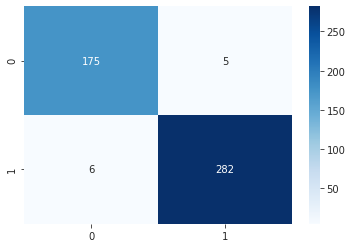

In [24]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

clf1 = RandomForestClassifier(random_state=1)
clf2 = GradientBoostingClassifier(random_state=1)
clf3 =  DecisionTreeClassifier(random_state=1)


params={"rf__max_depth":[8],
        "rf__criterion":["entropy"],
        "rf__n_estimators":[1000],
        "gb__loss":["deviance"],
        "gb__n_estimators":[1000],
        "gb__criterion":["friedman_mse"],
        "gb__max_depth":[2],
        "gb__max_features":["auto"],
        "dt__max_features":["auto"],
        "dt__criterion":["gini"],
        "dt__max_depth":[16]
        }

eclf = VotingClassifier(estimators=[("rf", clf1), ("gb", clf2), ("dt", clf3)],
                       voting= 'soft', weights = [3,1,1])
grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)
grid.fit(x_train, y_train)
grid_best = grid.best_estimator_
model_accuracy(classifier=grid_best, predictors=x_train, target=y_train)

From the confusion matrix, we can see that we have reduced the type II error, by using weighted voting classifier. Now let's check how it performs on the validation dataset.**

In [26]:
y_pred = grid_best.predict(x_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.97      0.98        32

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52



## Conclusion

We can see that we can acheive a significant accuracy using Random Forest Classifier but with the help of other two classifiers we are able to reduce type II error. Our main gole was to reduce Type II error and we can see that with a tradeoff of accuracy we are able to acheive it.

In [27]:
classifier_df = pd.DataFrame.from_dict(classifiers_description)
classifier_df.sort_values(by=["f1-score","standard_deviation"], ascending=False)

,model,precision,recall,f1-score,accuracy,standard_deviation
3,RandomForestClassifier,0.980835,0.980769,0.980787,0.980769,0.022754
6,VotingClassifier,0.976529,0.976496,0.976508,0.976549,0.022209
4,GradientBoostingClassifier,0.975031,0.975000,0.975012,0.975000,0.022835
2,DecisionTreeClassifier,0.971134,0.971154,0.971140,0.969231,0.019612
5,MLPClassifier,0.967346,0.967308,0.967323,0.967308,0.031068
1,LogisticRegression,0.923247,0.923077,0.923148,0.923077,0.032179
0,GaussianNB,0.878557,0.878846,0.878671,0.878846,0.055769
